In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications import EfficientNetB0

/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = tf.keras.utils.image_dataset_from_directory(
    './data/raw/Garbage classification/Garbage classification',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2527 files belonging to 6 classes.


In [3]:
ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
CLASS_NAMES = ds.class_names

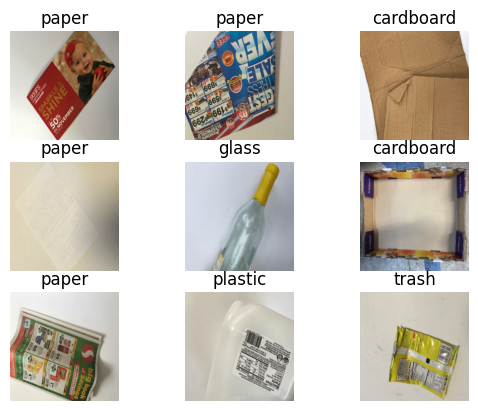

In [5]:
import matplotlib.pyplot as plt

for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [6]:
DATASET_SIZE = 2527

In [7]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

In [8]:
train_dataset = ds.take(train_size)
test_dataset = ds.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [9]:
NUM_CLASSES = len(CLASS_NAMES)

In [10]:
BATCH_SIZE = 32

In [11]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

In [12]:
train_dataset = train_dataset.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(input_preprocess)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [12]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers


inputs = layers.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 10 # @param {type: "slider", min:10, max:100}
hist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, 6)                 4057257   
 )                                                               
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 4015234 (15.32 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________
Epoch 1/10


ValueError: in user code:

    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/keras/src/backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 6) are incompatible
